# Pruebas de segmentación con el Catálogo Morfológico de Nebulosas Planetarias del IAC (SUPERVISADO)
En este documento vamos a probar las técnicas comentadas por Diego Cantorna en el documento de astrogestem (disponible en la carpeta astrosegstem de este mismo repositorio). Todas las técnicas testeadas en este Jupyter Notebook son de aprendizaje supervisado.

## 1. Carga del Dataset
Vamos a definir una clase, que tome como base la clase Sequence de Tensorflow, para poder cargar todo nuestro conjunto de imágenes de 2 canales con su máscara correspondiente.

In [16]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
route = "C:\\Users\\Lucan\\OneDrive - Universidade da Coruña\\Escritorio\\4_GCEID\\TFG\\test\\PNe_segmentation"
route = os.getcwd()#+ "/TFG/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print("\nEl directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print("\nContenido del directorio actual:")
for file in files:
    print("\t",file)
    
# Listamos el contenido del directorio de las máscaras
# masks_directory = route+"TFG\\test\\PNe_segmentation\\masks"
# data_directory = route+"TFG\\test\\PNe_segmentation\\data"
## Ejecución en el CESGA Finisterrae III
masks_directory = route+"/masks"
data_directory = route+"/data"


Vamos a cambiar el directorio de trabajo

El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/cursos/cursob82/TFG/PNe_segmentation

Contenido del directorio actual:
	 data
	 images
	 masks
	 data_files.csv
	 data_files_1c.csv
	 commands.txt
	 tf_fits
	 skfuzzy
	 segmentation_supervisada.ipynb
	 launch_jupyter.sh
	 commands_AIDA.txt
	 slurm-7135622.out
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 telegram_bot.py
	 train_py
	 slurm-7135879.out
	 train_sh
	 slurm-7157588.out
	 slurm-7168732.out


In [17]:
import glob
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import random as rd
import numpy as np
from astropy.io import fits

MinMaxNorm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

class NebulaeDataset(Dataset):
    
    def __init__(self, image_path, mask_path, dataframe, rsize = None, transform = None):
        super().__init__()
        
        self.image_path = image_path  # Ruta a las imágenes
        self.mask_path = mask_path  # Ruta a las máscaras
        
        # Cargar los nombres de las imágenes y máscaras desde el dataframe
        self.data_dict = dataframe.set_index('name').to_dict(orient='index')

        # Filtrar las rutas de archivo según los nombres en el dataframe
        self.img_files = [os.path.join(self.image_path, files['h']) for files in self.data_dict.values()]
        self.mask_files = [os.path.join(self.mask_path, files['mask']) for files in self.data_dict.values()]
        self.names = list(self.data_dict.keys())  # Nombres de las imágenes y máscaras
                
        self.rsize = rsize  # Size to use in default Resize transform
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        
        image = np.flip(fits.getdata(img_path, memmap=False).astype(np.float32), axis=0)
        mask = plt.imread(mask_path)
        
        # Take only the first channel. CHANGE THIS IF WE ARE GOING TO WORK WITH NUMEROUS CHANNELS
        if len(mask.shape) > 2:
            mask = mask[:,:,0]
        if len(image.shape) > 2:
            image = image[:,:,0]
        
        # Apply the defined transformations to both image and mask
        if self.transform is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            rd.seed(seed) # apply this seed to image transforms
            torch.manual_seed(seed)
            if type(self.transform) == tuple:
                image = self.transform[0](image)
            else:
                image = self.transform(image)
            rd.seed(seed) # apply the same seed to mask transforms
            torch.manual_seed(seed) 
            if type(self.transform) == tuple:
                mask = self.transform[1](mask)
            else:
                mask = self.transform(mask)
        else:
            if self.rsize is not None:
                t = transforms.Compose([
                    MinMaxNorm,
                    transforms.ToTensor(),
                    transforms.Resize(self.rsize, interpolation= InterpolationMode.NEAREST)
                    ])
            else:
                t = transforms.Compose([
                    MinMaxNorm,
                    transforms.ToTensor()
                    ])

            image = t(image)
            mask = t(mask)
        
        return image, mask

    def __len__(self):
        return len(self.img_files)
    
    def different_shapes(self):
        shapes = set([tuple(self[i][0].permute(2,1,0).shape) for i in range(len(self))])
        return list(shapes)
    
    def plot(self, index, plot_image = True, plot_mask = False):
        """
        Muestra una imagen y/o máscara aleatoria del lote.
        
        Parámetros:
        index (int): Índice del lote.
        plot_image (bool, opcional): Si es True, muestra la imagen. Por defecto es True.
        plot_mask (bool, opcional): Si es True, muestra la máscara. Por defecto es False.
        """
        image, mask = self[index]
        print(image.shape, mask.shape)
        image = image.permute(1,2,0)
        mask = mask.permute(1,2,0)
        name = self.names[index]
        
        if plot_image:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            fig.suptitle(f"Canales de la nebulosa {name}", fontweight = 'bold', fontsize = 14)
            ax.imshow(image, cmap = "gray")
            ax.set_title(f"Canal H")
            fig.show()
        if plot_mask:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            fig.suptitle(f"Máscara de la nebulosa {name}", fontweight = 'bold', fontsize = 14)
            ax.imshow(mask, cmap = "gray")
            fig.show()
            
    def different_shapes(self):
        shapes = set([tuple(self[i][0].permute(2,1,0).shape) for i in range(len(self))])
        return list(shapes)


Ahora deberíamos de ser capaces de poder cargar todas las imágenes, como tensores de PyTorch, de nuestro csv como un Dataset

In [18]:
import pandas as pd
df = pd.read_csv("data_files_1c.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df)

torch.Size([1, 492, 492]) torch.Size([1, 492, 492])


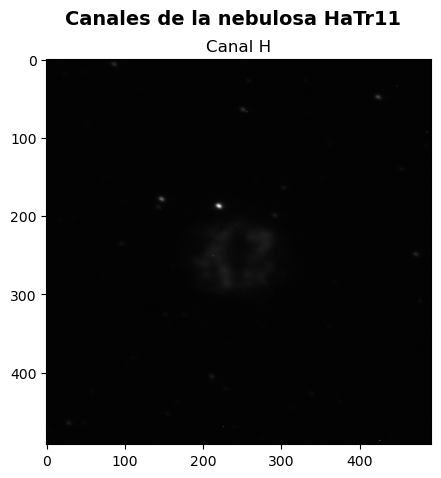

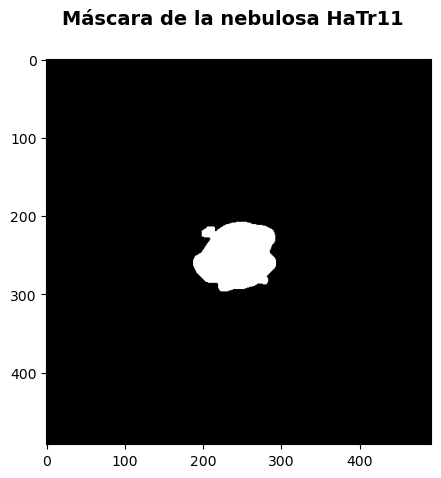

In [19]:
dataset.plot(40, plot_image = True, plot_mask = True)

## 2. Segmentación de las imágenes
Para la segmentación de las imágenes, vamos a probar diferentes algoritmos/técnicas propuestas por Diego Cantorna en el notebook de 'astrosegstem', pero para un mayor conjunto de datos para poder evaluarlas y verificar sus resultados.

### 2.0. Evaluación de resultados
Para evaluar el resultado de las técnicas de segmentación se pueden emplear distintas métricas.

Algunas de las métricas más utilizadas son la precisión, accuracy y recall, que junto al análisis de la matriz de confusión son las más utilizadas para cualquier problema de procesamiento de imágenes. A estas también se unen:
- **Coeficiente de Dice** (Dice Similarity Coefficient): Mide la similitud entre la segmentación predicha y la segmentación de referencia. Valores más cercanos a 1 indican una mejor superposición.
- **Índice de Jaccard** (Jaccard Index o Intersection over Union, IoU): Calcula la intersección entre la segmentación predicha y la segmentación de referencia dividida por su unión. También mide la superposición.
las cuales son métricas básicas y esenciales en los problemas de segmentación.

Vamos a utilizar todas estas métricas para evaluar nuestras técnicas de segmentación.

In [20]:
# from sklearn import metrics
# def dice_coef(y_true, y_pred, smooth=1):
#     intersection = np.sum(y_true * y_pred)
#     union = np.sum(y_true) + np.sum(y_pred)
#     dice = (2. * intersection + smooth) / (union + smooth)
#     return dice

# def evaluate_segmentation(mask, segmentation, confusion_matrix=False, verbose=False):
#     mask = tf.reshape(mask, -1)
#     segmentation = segmentation.ravel()
#     # Calcular el índice de Jaccard
#     jaccard = metrics.jaccard_score(mask, segmentation)
#     # Calcular el índice de DICE
#     dice = dice_coef(mask, segmentation)
#     # Calcular el índice de precisión
#     precision = metrics.precision_score(mask, segmentation)
#     # Calcular el índice de sensibilidad
#     recall = metrics.recall_score(mask, segmentation)
#     # Calcular el accuracy
#     accuracy = metrics.accuracy_score(mask, segmentation)

#     conf_matrix = None
    
#     if verbose:
#         # Imprimir los resultados	
#         print(f"Jaccard: {jaccard:.4f}\tDICE: {dice:.4f}\tPrecisión: {precision:.4f}\tSensibilidad: {recall:.4f}\n")
    
#     if confusion_matrix:
#         # Calcular la matriz de confusión
#         conf_matrix = metrics.confusion_matrix(mask, segmentation)
#         if verbose:
#             print(' Verdaderos negativos (TN):', conf_matrix[0, 0])

#             print(' Falsos positivos (FP):', conf_matrix[0, 1])

#             print(' Falsos negativos (FN):', conf_matrix[1, 0])

#             print(' Verdaderos positivos (TP):', conf_matrix[1, 1])
#             print('\n')

#         return jaccard, dice, accuracy, precision, recall, conf_matrix
    
#     return jaccard, dice, accuracy, precision, recall, conf_matrix

### 2.1. Técnicas de agrupamiento de datos
Las técnicas de agrupamiento (clustering) tratan de encontrar una partición de un
conjunto de datos de forma que los elementos de un mismo grupo sean más similares
que los elementos de grupos distintos. Esto permite resumir un conjunto de datos,
y puede facilitar algunos procesos de visualización o análisis posteriores con otras
técnicas.

### 2.1. K-Means
Vamos a comenzar por la técnica más básica (y en la que se basan la mayoría), K-Means.

Para aplicar el algoritmo se selecciona el número de grupos a utilizar y un prototipo (elemento representativo) de cada grupo. A continuación se realiza un proceso iterativo en el que se van asignando datos al grupo más próximo, se recalcula el prototipo de cada grupo, y se repite el proceso hasta que se estabiliza. 

En este caso aplicaremos el algoritmo a los píxeles de imágenes de niveles de gris, por lo que el prototipo de cada grupo será el valor de un píxel. El número de grupos podemos establecerlo manualmente, realizando pruebas con distintos valores. Existen algoritmos más complejos que tratan de automatizar el proceso, pero es interesante familiarizarse inicialmente con las versiones más simples de los algoritmos, para centrar el estudio en los aspectos fundamentales.


Las pruebas con el K-Means van a ser realizadas con un modelo K-Means para cada imagen (para ambos canales) normalizando los datos entre 0 y 1 y dejandolos con sus valores reales.

torch.Size([1, 246, 246]) torch.Size([1, 246, 246])


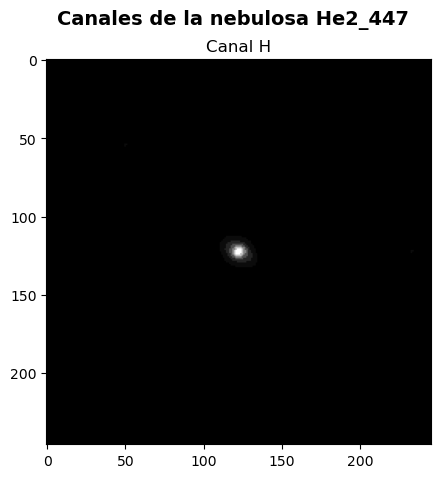

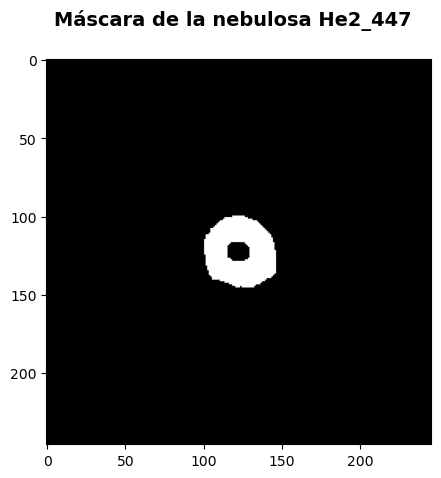

In [21]:
from typing import Any
from sklearn.cluster import KMeans

class ApplyKMeans:
    def __init__(self, concat = False, **kwargs):
        self.concat = concat
        self.kwargs = kwargs
    
    def __call__(self, im):
        im_array = im.reshape(-1, 1)
        # im_array = torch.reshape(im, (-1, 1))  # Redimensionar la imagen para el algoritmo K-Means
    
        kmeans = KMeans(**self.kwargs).fit(im_array)  # Entrenar el modelo K-Means
        
        # Obtener la imagen segmentada aplicando el algoritmo a cada píxel de la imagen
        im_segm_array = kmeans.predict(im_array)

        # Reemplazar los índices de los clústeres por los centroides de los clústeres
        im_segm_array = np.array([kmeans.cluster_centers_[i] for i in im_segm_array])

        # Cambiar las dimensiones de los datos segmentados para que se correspondan con la imagen inicial
        im_segm = im_segm_array.reshape(im.shape[0], im.shape[1], 1)
        
        if self.concat:
            im = np.expand_dims(im, axis=2)
            return np.concatenate((im, im_segm), axis=2)
        else:
            return im_segm

class CustomPad():
    def __init__(self, target_size = (1056, 1536), fill = 0):
        self.target_size = target_size
        self.fill = fill
        
    def __call__(self, image):
        # Get the size of the input image
        width, height = image.shape[2], image.shape[1]

        # Compute the size of the padding
        pad_width = self.target_size[1] - width
        pad_height = self.target_size[0] - height

        # Compute the padding
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        # Apply the padding
        return transforms.functional.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill = self.fill)
    
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyKMeans(concat=False, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

dataset.plot(55, plot_image = True, plot_mask = True)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import segmentation_models_pytorch as smp
import lightning as L
import torchmetrics as tm

class MLPClassifier(torch.nn.Module):
        
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        
        self.layer1_linear = nn.Linear(input_dim, hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1_linear(x))
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            
        return self.output_layer(x)
    
def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold)*1.0
    return masks

metrics_fncs = {
    "accuracy": tm.Accuracy, 
    "precision": tm.Precision, 
    "recall": tm.Recall, 
    "f1": tm.F1Score
    }

class MLPModel(L.LightningModule):
    def __init__(self, model, learning_rate = 0.0001, loss_fn = nn.BCEWithLogitsLoss, optimizer = Adam, threshold = 0.5, current_fold = 0):
        super().__init__()
        self.model = model
        
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn()
        self.optimizer = optimizer
        self.threshold = threshold
        
        self.current_fold = current_fold
        
        self.metrics_train = nn.ModuleDict({'train_accuracy': tm.Accuracy(task="binary", threshold=self.threshold), 'train_iou': tm.JaccardIndex(task="binary", threshold=self.threshold)})#, 'train_dice': tm.Dice(task="binary", threshold=self.threshold)})
        self.metrics_val = nn.ModuleDict({f"val_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        self.metrics_test = nn.ModuleDict({f"test_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        
        self.metrics_dict = nn.ModuleDict({
            "train_metrics": nn.ModuleDict({f"train_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()}),
            "val_metrics": nn.ModuleDict({f"val_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()}),
            "test_metrics": nn.ModuleDict({f"test_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        })
        
        self.stage_step_outputs = {'train': [], 'val': [], 'test': []}
        
        self.save_hyperparameters()
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        x, y = batch
        y_logits = self(x)
        
        loss = self.loss_fn(y_logits, y)
        # self.log(f"{stage}_loss", loss)
        
        y_hat = torch.sigmoid(y_logits)
        
        for metric_name, metric_fnc in self.metrics_dict[stage+"_metrics"].items():
            metric_fnc(y_hat, y)
            self.log(f"{metric_name}", metric_fnc, sync_dist=True)
        
        self.stage_step_outputs[stage].append({"loss": loss})
        
        return {"loss": loss}
        
    def shared_epoch_end(self, outputs, stage):
        total_loss = 0
        iter_count = len(outputs)
        
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()
        
        metrics = {
            f"{stage}_fold": self.current_fold,
            f"{stage}_loss": total_loss/iter_count,
        }
        
        self.log_dict(metrics, sync_dist = True)
        
        self.stage_step_outputs[stage].clear()
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        outputs = self.stage_step_outputs['train']
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        outputs = self.stage_step_outputs['val']
        return self.shared_epoch_end(outputs, "val")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        outputs = self.stage_step_outputs['test']
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.learning_rate)

In [23]:
def classBalancing(subset, size = None):
    x_trainBal = torch.empty((1, 0))
    y_trainBal = torch.empty((1, 0))
    
    for x, y in subset:
        xFlat = x.view(1, -1)#x.reshape(-1, X_train.shape[-1])
        yFlat = y.reshape(1, -1)
    
        idxObject = np.where(yFlat == 1)[0]
        idxBackground = np.where(yFlat == 0)[0]
        
        np.random.shuffle(idxBackground)
        if size == None:
            idxs = np.concatenate((idxObject, idxBackground[:len(idxObject)]))
        else:
            np.random.shuffle(idxObject)
            idxs = np.concatenate((idxObject[:size], idxBackground[:size]))

        np.random.shuffle(idxs)
        
        x_trainBal = torch.concatenate((x_trainBal, xFlat[:,idxs]), dim=1)
        y_trainBal = torch.concatenate((y_trainBal, yFlat[:,idxs]), dim=1)
        
    return x_trainBal, y_trainBal

def testFlatten(subset):
    x_testFlat = torch.empty((1, 0))
    y_testFlat = torch.empty((1, 0))
    for x, y in subset:
        xFlat = x.view(1,-1)#x.reshape(-1, X_train.shape[-1])
        yFlat = y.reshape(1, -1)
        
        x_testFlat = torch.concatenate((x_testFlat, xFlat), dim = 1)
        y_testFlat = torch.concatenate((y_testFlat, yFlat), dim = 1)
        
    return x_testFlat, y_testFlat


class FlattenSubset(Dataset):
    """
    Dataset wrapper personalizado que aplica la transformación (si se le introduce) a un Subset dado.

    Args:
        subset (torch.utils.data.Dataset): Subset del dataset original.
        transform (callable, optional): Función de transformación para aplicar a los datos introducidos. Default is None.
    """
    def __init__(self, subset, train = False):
        self.subset = subset
        self.train = train
        
        if train:
            self.x_flatten, self.y_flatten = classBalancing(subset)
        else:
            self.x_flatten, self.y_flatten = testFlatten(subset)
            
    def __getitem__(self, index):
        x = self.x_flatten[0][index]
        y = self.y_flatten[0][index]
        return x, y

    def __len__(self):
        return len(self.x_flatten)
    
# f_subset = FlattenSubset(test_subset, train = False)

In [23]:
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import KFold
import wandb

BATCH_SIZE = 256
num_epochs = 10000

os.environ["WANDB_API_KEY"] = "21924e6e134841c5c16842c4ac42fcbe5a66feb2"
        
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyKMeans(concat=False, n_clusters=5, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    CustomPad(target_size = (980, 980), fill = -1)
                    ])

# Definimos el K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

# Comenzamos a imprimir los resultados
print('--------------------------------')

# Comenzamos a evaluar el modelo gracias al K-Fold Cross Validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    model = MLPClassifier(1, [10, 5], 1)
                
    # Definimos el modelo con los pesos inicializados aleatoriamente (sin preentrenar)
    model = MLPModel(model = model)

    ruta_logs_wandb = os.environ["STORE"] + "/AIDA/p2/logs_wandb/"
    logger_wandb = WandbLogger(project="segmentation_TFG", log_model = False, name="KNN_MLP", save_dir=ruta_logs_wandb)
    logger_wandb.experiment.config.update({"model_name": "KNN_MLP"})

    # log gradients, parameter histogram and model topology
    logger_wandb.watch(model, log="all")

    trainer = L.Trainer(strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger= logger_wandb)

    # Imprimimos el fold del que van a mostrarse los resultados
    print('--------------------------------')
    print(f"Model info:\n\t- Batch Size: {BATCH_SIZE}\n\t- GPUs on use: {torch.cuda.device_count()}")

    # Creamos nuestros propios Subsets de PyTorch aplicando a cada conjunto la transformacion deseada
    train_subset = FlattenSubset(torch.utils.data.Subset(dataset, train_ids), train = True)
    test_subset = FlattenSubset(torch.utils.data.Subset(dataset, test_ids), train = False)

    # Definimos un data loader por cada conjunto de datos que vamos a utilizar.
    trainloader = torch.utils.data.DataLoader(
                            train_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=True, persistent_workers=True)

    testloader = torch.utils.data.DataLoader(
                            test_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)

    # Entrenamos el modelo, extrayendo los resultados y guardandolos en la variable result, y evaluamos en el conjunto de test.
    trainer.fit(model, trainloader) 

    logger_wandb.experiment.unwatch(model)

    # trainer.test(model, testloader) 
    # Creamos un nuevo entrenador con una sola GPU para la fase de prueba
    trainer_test = L.Trainer(devices = 1, strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger=logger_wandb)
    trainer_test.test(model, testloader)

    logger_wandb.finalize("success")
    wandb.finish()
    break

/mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


--------------------------------
--------------------------------
Model info:
	- Batch Size: 256
	- GPUs on use: 1


/mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/cond ...
/mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:44: attribute 'model' removed from hparams because it cannot be pickled
/mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | MLPClassifie

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=10000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
         test_f1                    0.0
        test_fold                   0.0
        test_loss          0.0013717536348849535
     test_precision                 0.0
       test_recall                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_f1,▁
test_fold,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁█████████████████████████████████████
train_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▆▆▅▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


### NOTA: ARREGLAR PROBLEMA CON LAS MÉTRICAS Y ADAPTAR PARA FUNCIONAR CON LA COMBINACIÓN IMAGEN_ORIGINAL + KNN

### U-Net (Simple)

In [24]:
import torch.optim as optim
import torch.nn as nn
import lightning as L
import segmentation_models_pytorch as smp

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   

class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold)*1.0
    return masks

class UNETModel(L.LightningModule):
    
    def __init__(self, model, learning_rate = 0.0001, loss_fn = smp.losses.DiceLoss, optimizer = optim.Adam, threshold = 0.5, current_fold = 0):
        super().__init__()
        self.model = model
        
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn(smp.losses.BINARY_MODE, from_logits=True)
        self.optimizer = optimizer
        self.threshold = threshold
        
        self.current_fold = current_fold
        
        self.stage_step_outputs = {'train': [], 'val': [], 'test': []}
        # self.metrics_train = nn.ModuleDict({'train_accuracy': tm.Accuracy(task="binary", threshold=self.threshold), 'train_iou': tm.JaccardIndex(task="binary", threshold=self.threshold)})#, 'train_dice': tm.Dice(task="binary", threshold=self.threshold)})
        # self.metrics_val = nn.ModuleDict({f"val_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        # self.metrics_test = nn.ModuleDict({f"test_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        
        self.save_hyperparameters()
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        x, y = batch
        y_logits = self(x)
        
        loss = self.loss_fn(y_logits, y)
    
        # self.log(f"{stage}_loss", loss)
        
        y_hat = get_segmentation_masks(y_logits, self.threshold)
        
        tp, fp, fn, tn = smp.metrics.get_stats(y_hat.long(), y.long(), mode="binary")
        
        self.stage_step_outputs[stage].append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})
        
        return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}
        
    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([m["tp"] for m in outputs])
        fp = torch.cat([m["fp"] for m in outputs])
        fn = torch.cat([m["fn"] for m in outputs])
        tn = torch.cat([m["tn"] for m in outputs])
        
        total_loss = 0
        iter_count = len(outputs)
        
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()
        
        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")

        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        metrics = {
            f"{stage}_fold": self.current_fold,
            f"{stage}_loss": total_loss/iter_count,
            f"{stage}_precision": precision,
            f"{stage}_recall": recall,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score,
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, sync_dist = True)
        
        self.stage_step_outputs[stage].clear()
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        outputs = self.stage_step_outputs['train']
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        outputs = self.stage_step_outputs['val']
        return self.shared_epoch_end(outputs, "val")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        outputs = self.stage_step_outputs['test']
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

torch.Size([1, 992, 992]) torch.Size([1, 992, 992])


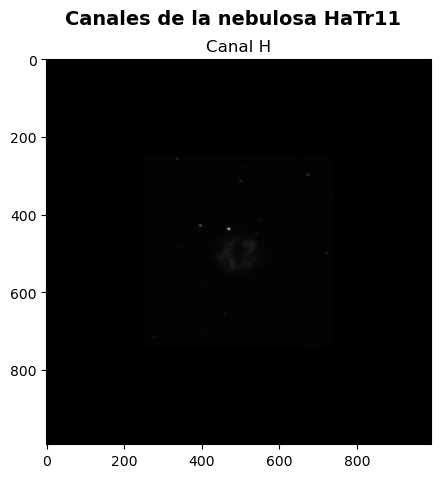

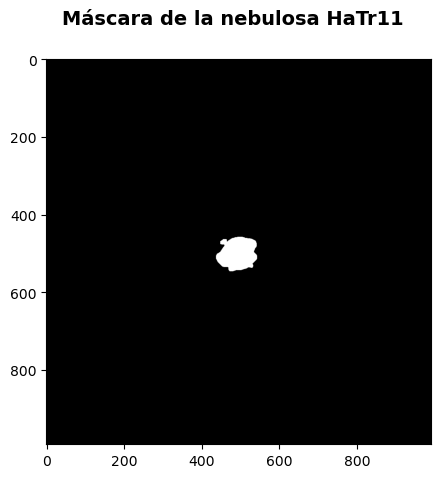

In [43]:
TypicalImageNorm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) * 255
# NoNegativeNorm = lambda x: x - np.min(x) if np.min(x) < 0. else x
# print_function = lambda x: print(np.min(x))

class CustomPad():
    def __init__(self, target_size = (980, 980), fill = 0, fill_min = False):
        self.target_size = target_size
        self.fill = fill
        self.fill_min = fill_min
        
    def __call__(self, image):
        # Get the size of the input image
        width, height = image.shape[2], image.shape[1]

        # Compute the size of the padding
        pad_width = self.target_size[1] - width
        pad_height = self.target_size[0] - height

        # Compute the padding
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        if self.fill_min:
            self.fill = image.min().item()
            
        # Apply the padding
        return transforms.functional.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill = self.fill)
    
class NoNegativeNorm():
    def __init__(self):
        pass
    
    def __call__(self, image):
        if np.min(image) < 0:
            image = image - np.min(image)
        
        return np.copy(image)

class NoNorm():
    def __init__(self):
        pass
    
    def __call__(self, image):
        return np.copy(image)
    
transform_x = transforms.Compose([
                    NoNorm(),
                    # NoNegativeNorm(),
                    # print_function,
                    transforms.ToTensor(),
                    CustomPad(target_size = (992, 992), fill_min=True)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    CustomPad(target_size = (992, 992), fill = 0)
                    ])

# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

dataset.plot(40, plot_image = True, plot_mask = True)

In [44]:
import wandb
class PrintCallback(L.pytorch.Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is started!")
        
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        
        # Let's log 20 sample image predictions from first batch
        if (trainer.current_epoch % 50 == 0 and trainer.current_epoch != 0) or trainer.current_epoch == trainer.max_epochs-1:
            if batch_idx == 0:
                n = 4
                x, y = batch
                
                outputs = get_segmentation_masks(pl_module(x))
                
                columns = ["image", "ground truth", "prediction"]
                data = [
                    [wandb.Image(x_i), wandb.Image(y_i), wandb.Image(y_pred)] for x_i,
                    y_i,
                    y_pred in list(zip(x, y, outputs))
                ]
                
                trainer.loggers[-1].log_table(key=f"table_epoch_{trainer.current_epoch}_fold_{pl_module.current_fold}", columns=columns, data=data)

    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        
        x, y = batch
        outputs = get_segmentation_masks(pl_module(x))
                
        columns = ["image", "ground truth", "prediction"]
        data = [
            [wandb.Image(x_i), wandb.Image(y_i), wandb.Image(y_pred)] for x_i,
            y_i,
            y_pred in list(zip(x, y, outputs))
        ]
        
        trainer.loggers[-1].log_table(key=f"table_test_fold_{pl_module.current_fold}_batch_{batch_idx}", columns=columns, data=data)

In [45]:
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import KFold
import wandb

BATCH_SIZE = 8
num_epochs = 1000
model_name = "UNET_base"
os.environ["WANDB_API_KEY"] = "21924e6e134841c5c16842c4ac42fcbe5a66feb2"

# Fijamos una semilla (se hace para cada librería por que cada una tiene una manera de generar pseudoaleatorios)
L.pytorch.seed_everything(42, workers = True)

# Definimos el K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

# Comenzamos a imprimir los resultados
print('--------------------------------')

# Comenzamos a evaluar el modelo gracias al K-Fold Cross Validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    callbacks = [PrintCallback()]
    
    model = UNet(input_channels = dataset[0][0].shape[0], n_class = 1)
    
    # Definimos el modelo con los pesos inicializados aleatoriamente (sin preentrenar)
    model = UNETModel(model = model, learning_rate=2e-6, current_fold=fold)

    ruta_logs_wandb = os.environ["STORE"] + "/AIDA/p2/logs_wandb/"
    logger_wandb = WandbLogger(project="segmentation_TFG", log_model = False, name=model_name, save_dir=ruta_logs_wandb)
    logger_wandb.experiment.config.update({"model_name": model_name})

    # log gradients, parameter histogram and model topology
    logger_wandb.watch(model, log="all")

    trainer = L.Trainer(strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger= logger_wandb, callbacks=callbacks)

    # Imprimimos el fold del que van a mostrarse los resultados
    print('--------------------------------')
    print(f"Model info:\n\t- Batch Size: {BATCH_SIZE}\n\t- GPUs on use: {torch.cuda.device_count()}")

    # Creamos nuestros propios Subsets de PyTorch aplicando a cada conjunto la transformacion deseada
    train_subset = torch.utils.data.Subset(dataset, train_ids)
    test_subset = torch.utils.data.Subset(dataset, test_ids)

    # Definimos un data loader por cada conjunto de datos que vamos a utilizar.
    trainloader = torch.utils.data.DataLoader(
                            train_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=True, persistent_workers=True)

    testloader = torch.utils.data.DataLoader(
                            test_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)

    # Entrenamos el modelo, extrayendo los resultados y guardandolos en la variable result, y evaluamos en el conjunto de test.
    trainer.fit(model, trainloader) 

    logger_wandb.experiment.unwatch(model)

    # trainer.test(model, testloader) 
    # Creamos un nuevo entrenador con una sola GPU para la fase de prueba
    trainer_test = L.Trainer(devices = 1, strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger=logger_wandb, callbacks=callbacks)
    trainer_test.test(model, testloader)

    logger_wandb.finalize("success")
    wandb.finish()
    break

[rank: 0] Seed set to 42
/mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


--------------------------------


cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:44: attribute 'model' removed from hparams because it cannot be pickled
/mnt/netapp2/Store_uni/home/ulc/cursos/cursob82/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size

--------------------------------
Model info:
	- Batch Size: 8
	- GPUs on use: 1
Training is started!


Training: |          | 0/? [00:00<?, ?it/s]